In [24]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
from pandas import to_datetime
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr, iqr

In [25]:
customer_indicators = pd.read_csv("../../indicators.csv", index_col=0)
customer_indicators

,I,Iu,spending,Imax,avg_bought,baskets,E
CustomerID,,,,,,,
12347.0,0.108021,0.059890,0.124483,0.217940,0.019291,0.031579,0.628584
12348.0,0.002658,0.003964,0.071554,0.002658,0.274122,0.000000,0.000000
12349.0,0.307641,0.311199,0.368923,0.307641,0.023277,0.000000,0.585006
12350.0,0.112957,0.073340,0.081727,0.112957,0.008866,0.000000,0.393407
12352.0,0.044423,0.037944,0.064072,0.067110,0.033188,0.031579,0.551425
...,...,...,...,...,...,...,...
18280.0,0.028571,0.048563,0.053783,0.028571,0.030539,0.000000,0.324265
18281.0,0.033223,0.023786,0.013787,0.033223,0.005147,0.000000,0.230642
18282.0,0.016279,0.021308,0.020487,0.017276,0.025711,0.005263,0.299490


In [26]:
def target_label(row):
    first_third = customer_indicators["spending"].quantile(0.33)
    second_third = customer_indicators["spending"].quantile(0.66)
    if (row["spending"] <= first_third):
        return 1
    elif (row["spending"] > first_third and row["spending"] <= second_third):
        return 2
    return 3

customer_indicators["label"] = customer_indicators.apply(target_label, axis=1)

In [27]:
from sklearn.model_selection import train_test_split

customer_indicatorsForClass=customer_indicators.copy()

#extract and remove original label values
originalLabel=customer_indicatorsForClass["label"].values
customer_indicatorsForClass=customer_indicatorsForClass.drop(columns=['label'])
#generate training and test set
train_set, test_set, train_label, test_label = train_test_split(
    customer_indicatorsForClass,
    originalLabel,
    stratify = originalLabel,
    test_size=0.40
)

In [28]:
print(train_set)
print(train_label.shape)
print(test_set)
print(test_label.shape)

                   I        Iu  spending      Imax  avg_bought   baskets  \
CustomerID                                                                 
14699.0     0.039203  0.033697  0.029288  0.039203    0.014426  0.000000   
14828.0     0.014618  0.008920  0.054680  0.014618    0.050483  0.000000   
13599.0     0.039635  0.028494  0.036147  0.106312    0.016296  0.100000   
16009.0     0.063344  0.094813  0.080410  0.108970    0.021674  0.010526   
16582.0     0.010631  0.008920  0.008455  0.010631    0.009350  0.000000   
...              ...       ...       ...       ...         ...       ...   
12685.0     0.115282  0.080773  0.122868  0.294352    0.019794  0.026316   
12410.0     0.044850  0.055996  0.091548  0.085714    0.046110  0.005263   
16755.0     0.091916  0.131153  0.097128  0.102326    0.015862  0.010526   
12729.0     0.100332  0.108028  0.117286  0.100332    0.026790  0.000000   
13351.0     0.059801  0.068385  0.087693  0.059801    0.023631  0.000000   

           

Funzione di grid search dei migliori parametri di un algoritmo:

In [29]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, y, grid_params, model, jobs = 1):
    gs = GridSearchCV(
        model,
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = 1
    )
    gs_result = gs.fit(X, y)
    return gs_result.best_score_, gs_result.best_estimator_, gs_result.best_params_

Funzione di plotting della matrice di confusione con seaborn (per il salvataggio su disco):

In [30]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    ax = sn.heatmap(conf, annot=True)
    ax.set(xlabel = "Predicted label", ylabel = "True label")

# K-Nearest Neighbors

Si usa l'implementazione contenuta in SciKit-Learn, validando i parametri con una grid search.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

grid_params = {
    "n_neighbors": list(range(1, 10)),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    KNeighborsClassifier()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed:   17.2s finished


0.9042615805084994

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=9,
                     weights='distance')

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 9,
 'weights': 'distance'}

Usiamo i parametri trovati per eseguire il training sull'intero training set e la predizione dei risultati

In [32]:
knn = KNeighborsClassifier(**best_params)
knn.fit(train_set, train_label)
pred_label = knn.predict(test_set)

Verifichiamo i risultati attraverso la matrice di confusione:

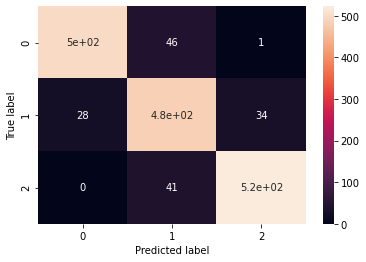

In [33]:
plot_confusion_matrix(test_label, pred_label)


Facciamo restituire un report della precisione, del recall e dello f1-score:

In [34]:
from sklearn.metrics import classification_report

print(classification_report(test_label, pred_label))

              precision    recall  f1-score   support

           1       0.95      0.91      0.93       547
           2       0.85      0.89      0.87       547
           3       0.94      0.93      0.93       564

    accuracy                           0.91      1658
   macro avg       0.91      0.91      0.91      1658
weighted avg       0.91      0.91      0.91      1658



# Support Vector Machine

Esistono molte implementazioni di Support Vector Machine dedicate a problemi di classificazione. 

## Support Vector Classification (`SVC`)

In [35]:
from sklearn.svm import SVC

C_values = [2**(i) for i in range(-5, 15, 2)]

gamma_values = [2**(i) for i in range(-15, 3, 2)] + ["auto", "scale"]

grid_params = {
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "C": C_values,
    "gamma": gamma_values,
    "shrinking": [True, False]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    SVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 880 candidates, totalling 2640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2640 out of 2640 | elapsed:  4.1min finished


0.9915522067407524

SVC(C=8192, gamma=3.0517578125e-05, kernel='linear')

{'C': 8192, 'gamma': 3.0517578125e-05, 'kernel': 'linear', 'shrinking': True}

Si indaga ulteriormente con un'altra 3-fold validation con C che varia da 2^12 a 2^13 e con gamma che varia da 

In [36]:
from sklearn.svm import SVC

C_values = np.linspace(2**12, 2**13, 11)

gamma_values = list(np.linspace(2**(-15), 2**(-14), 11)) + ["auto", "scale"]

grid_params = {
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "C": C_values,
    "gamma": gamma_values,
    "shrinking": [True, False]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    SVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 1144 candidates, totalling 3432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3432 out of 3432 | elapsed:  8.8min finished


0.9923568741028227

SVC(C=6144.0, gamma=3.0517578125e-05, kernel='linear')

{'C': 6144.0, 'gamma': 3.0517578125e-05, 'kernel': 'linear', 'shrinking': True}

In [37]:
svc = SVC(**best_params)
svc.fit(train_set, train_label)
pred_label = svc.predict(test_set)

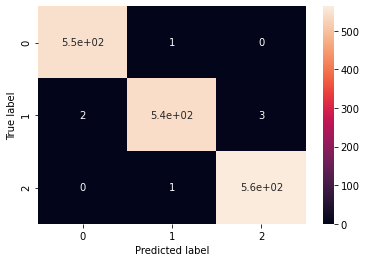

In [38]:
plot_confusion_matrix(test_label, pred_label)

In [39]:
from sklearn.metrics import classification_report

print(classification_report(test_label, pred_label))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       547
           2       1.00      0.99      0.99       547
           3       0.99      1.00      1.00       564

    accuracy                           1.00      1658
   macro avg       1.00      1.00      1.00      1658
weighted avg       1.00      1.00      1.00      1658



## $\nu$ - Support Vector Classification (`NuSVC`)

Implementazione che prende come iperparametro un limite inferiore alla percentuale di vettori di supporto.

In [71]:
from sklearn.svm import NuSVC

nu_values = np.linspace(0.1, 1, 13)

gamma_values = [2**(i) for i in range(-15, 3, 2)] + ["auto", "scale"]

grid_params = {
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "nu": nu_values,
    "gamma": gamma_values,
    "shrinking": [True, False]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    NuSVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 1144 candidates, totalling 3432 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3432 out of 3432 | elapsed:  6.4min finished


0.9883340229094674

NuSVC(gamma=3.0517578125e-05, kernel='linear', nu=0.1)

{'gamma': 3.0517578125e-05, 'kernel': 'linear', 'nu': 0.1, 'shrinking': True}

Per completezza si espande la grid search per il parametro $\gamma$ da $2^{-15}$ a $2^{-14}$, analogamente al punto precedente.

In [73]:
from sklearn.svm import NuSVC

nu_values = [0.1]

gamma_values = list(np.linspace(2**(-15), 2**(-14), 11)) + ["auto", "scale"]

grid_params = {
    "kernel": ["linear"],
    "nu": nu_values,
    "gamma": gamma_values,
    "shrinking": [True]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    NuSVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    2.1s finished


0.9883340229094674

NuSVC(gamma=3.0517578125e-05, kernel='linear', nu=0.1)

{'gamma': 3.0517578125e-05, 'kernel': 'linear', 'nu': 0.1, 'shrinking': True}

Si usano tali parametri per il training:

              precision    recall  f1-score   support

           1       0.99      0.98      0.99       547
           2       0.97      0.99      0.98       547
           3       1.00      0.99      0.99       564

    accuracy                           0.99      1658
   macro avg       0.99      0.99      0.99      1658
weighted avg       0.99      0.99      0.99      1658



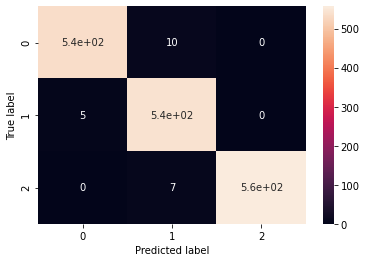

In [74]:
nu_svc = NuSVC(**best_params)
nu_svc.fit(train_set, train_label)
pred_label = nu_svc.predict(test_set)
plot_confusion_matrix(test_label, pred_label)
plt.savefig("./nu-svc-conf.png")
print(classification_report(test_label, pred_label))

## Linear Support Vector Classification (`LinearSVC`)

Implementazione di SVM con kernel lineare, basata su `liblinear`, che rende possibile maggiore flessibilità nella scelta della funzione di loss.

Dato che il parametro $C$ è stato validato nell'uso delle precedenti implementazioni, lo si fissa e si procede alla cross-validation al variare di tutti gli altri iperparametri:

In [40]:
from sklearn.svm import LinearSVC

grid_params = {
    "C": [7372.8],
    "penalty": ["l1", "l2"],
    "loss": ["hinge", "squared_hinge"],
    "dual": [True, False],
    "multi_class": ["ovr", "crammer_singer"],
    "fit_intercept": [True, False],
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    LinearSVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py", line 821, in _get_liblinear_solver_type
    raise ValueError('Un

C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the 

C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the 

C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the 

C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the 

0.9919538119962938

LinearSVC(C=7372.8, multi_class='crammer_singer', penalty='l1')

{'C': 7372.8,
 'dual': True,
 'fit_intercept': True,
 'loss': 'squared_hinge',
 'multi_class': 'crammer_singer',
 'penalty': 'l1'}

C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

           1       1.00      1.00      1.00       547
           2       1.00      0.99      0.99       547
           3       0.99      1.00      1.00       564

    accuracy                           1.00      1658
   macro avg       1.00      1.00      1.00      1658
weighted avg       1.00      1.00      1.00      1658



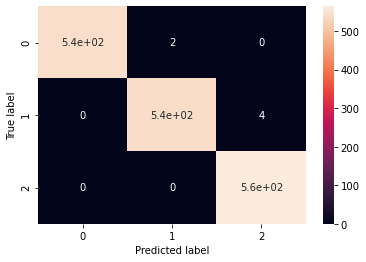

In [41]:
linear_svc = LinearSVC(**best_params)
linear_svc.fit(train_set, train_label)
pred_label = linear_svc.predict(test_set)
plot_confusion_matrix(test_label, pred_label)
plt.savefig("./linear-svc-conf.png")
print(classification_report(test_label, pred_label))

## Classificazione con Random Forest

Grid search per la ricerca dei parametri migliori

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,4,5,6,7,10,12,None],
              "max_features": [2,3],
              "min_samples_split": sp_randint(10, 100),
              "min_samples_leaf": sp_randint(10, 100),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 32, 'min_samples_split': 24}
Mean and std of this setting  0.9995975855130783 0.0008048289738430635


In [11]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='entropy',
                             max_features=3,
                             max_depth=5, 
                             min_samples_split=24,
                             min_samples_leaf=32,
                             bootstrap=False,
                            class_weight= "balanced") 
rf = rf.fit(train_set, train_label)

In [12]:
test_pred_rf = rf.predict(test_set)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(test_label, test_pred_rf))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       547
           2       1.00      1.00      1.00       547
           3       1.00      1.00      1.00       564

    accuracy                           1.00      1658
   macro avg       1.00      1.00      1.00      1658
weighted avg       1.00      1.00      1.00      1658



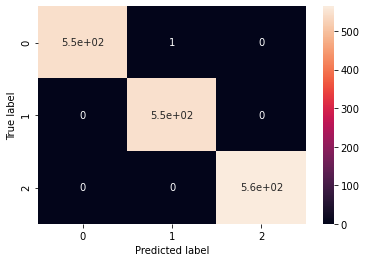

In [18]:
plot_confusion_matrix(test_label, test_pred_rf)

## Classificazione con Naive Bayes

In [19]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [20]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

           1       0.90      0.90      0.90       547
           2       0.76      0.85      0.80       547
           3       0.94      0.83      0.88       564

    accuracy                           0.86      1658
   macro avg       0.87      0.86      0.86      1658
weighted avg       0.87      0.86      0.86      1658



Plot con valori di test

(0.0, 0.4)

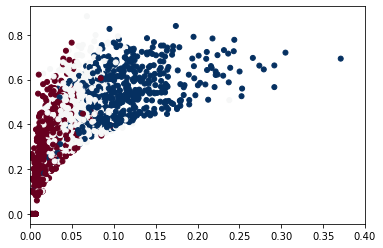

In [21]:
from sklearn.datasets import make_blobs
plt.scatter(test_set["I"], test_set["E"], c=test_label, s=25, cmap='RdBu')
plt.xlim(0, 0.4)


Plot con valori previsti

(0.0, 0.4)

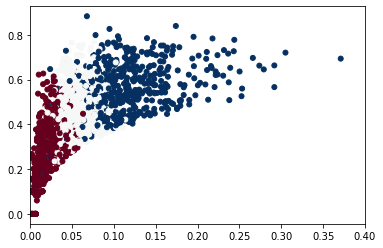

In [22]:
plt.scatter(test_set["I"], test_set["E"], c=test_pred_gnb, s=25, cmap='RdBu')
plt.xlim(0, 0.4)